In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Load the images dataset and normalize it to [0..1] range We will use only its train part, so skip the testing.

In [3]:
(x_train, y_train), (_ , _) = tf.keras.datasets.mnist.load_data()
datax = x_train/255.0

Define dimensionality of the input data, of latent space and leaking coefficient for LeakyReLU units. Please note that 2D latent space is inadequate for complex data description such as spectra, so prediction will probably be far from perfection, but it will allow us to visualize the space later.

In [4]:
inp_dim = datax.shape[1:3]
hidden_dim = 2
a = 0.1

Reparametrization trick - instead of sampling from $q(Z|X)=\mathcal{N}(\mu(X,\theta),\Sigma(X,\theta))$, which is indifferentiable, we sample from $\mathcal{N}(0,1)$ and use properties of normal distribution, namely 
$$ X \sim \mathcal{N}(0,1) \\
\Sigma^{1/2}X+\mathbf{\mu} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$$
to shift mean and scale variance. We've assumed diagonality of $\Sigma$, so multiplication by $\Sigma^{1/2}$ can be replaced with pointwise multiplication by the vector of diagonal standard deviations $\sqrt{\mathbf{\sigma^2}}$, predicted by the encoder.

Since later calculation involve taking log of the variance, it is useful to assume that NN model already predicts log of variance, which will save us from getting NaNs if model output negative number. Thus, here we need to exponentiate log of variance to get $\mathbf{\sigma}^2$, or even better divide by two before exponentiation to directly get $\mathbf{\sigma}$

In [5]:
def reparametrization(mu, log_sigma):
    batch_size = tf.shape(mu)[0]
    epsilon = tf.random.normal(shape=(batch_size, hidden_dim), mean=0.0, stddev=1.0)
    return tf.math.exp(log_sigma/2)*epsilon+mu

Now define convolutional encoder model. Predicted $\mathbf{\mu}$ and $\mathbf{\sigma}$ are used to sample from $q(Z|X)$.

In [6]:
data_input = Input(shape=(inp_dim[0],inp_dim[1],1))

x = Conv2D(4, (3,3), padding="same")(data_input)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(4, (3,3), padding="same")(x)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(8, (3,3), padding="same")(x)
x = LeakyReLU(a)(x)

x = Flatten()(x)

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

mu = Dense(hidden_dim, activation="linear")(x)
log_sigma_diag = Dense(hidden_dim, activation="linear")(x)

enc_out = reparametrization(mu, log_sigma_diag)

encoder = Model(data_input, enc_out)

Similarly, define decoder, that approximates $p(X|Z)$.

In [7]:
hidden_input = Input(shape=(hidden_dim,))
x = Dense(100, activation="linear")(hidden_input)
x = LeakyReLU(a)(x)

x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dense(8*inp_dim[0]//4*inp_dim[1]//4, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Reshape((inp_dim[0]//4, inp_dim[1]//4, 8))(x)

x = Conv2D(8, (3,3), padding="same")(x)
x = LeakyReLU(a)(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(4, (3,3), padding="same")(x)
x = LeakyReLU(a)(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(1, (3,3), padding="same")(x)
dec_out = LeakyReLU(a)(x)

decoder = Model(hidden_input, dec_out)

Now, the optimization criterion is given by:
    $$\mathbb{E}_{X\sim D}\Big[\mathbb{E}_{\mathcal{E}\sim\mathcal{N}(\mathbf{0},I)}\big[\text{log}\,p\big(X|z=\mu(X,\theta_{1})+\sigma^{2}(X,\theta_{1})\mathcal{E}\big)\big]-D_{KL}[q(Z|X,\theta_{2})||p(Z)]\Big]$$
Its first part maximizes probability to observe the data $X$ at the decoder output. We will replace it with reconstruction loss, a simple sum of squared errors.

In [8]:
def sse_loss(X_true, X_reconst):
    loss = K.sum((X_true - X_reconst)**2, axis=[-1,-2,-3])
    return  loss

The second part of the optimization criterion minimizes Kullback-Leibler divergence between encoder output and its desired shape ($\mathcal{N}(\mathbf{0},I)$ in that case). The divergence is given by $$\frac{1}{2}[\text{tr}\,\Sigma(X)+\mu(X)^{T}\mu(X)-k-\text{log}\,\det\Sigma(X)]$$

since our model already outputs logarithm of the $\Sigma$ diagonal, we need to exponentiate and sum it to get $\text{tr}\,\Sigma(X)$, vector $\mu$ can be squared elementwise and added. Determinant of diagonal matrix is equal to the the product of diagonal elements, and since we already have logarithms of them it simplifies to the summation of the vector of logarithms. Since all three summation are performed over same exis (hidden space dimensionality) we wil replace them by a single sum and subtract $k$. As a final step we use K.mean to get average divergence over batch.

In [9]:
kl_loss =  0.5*(K.sum(K.exp(log_sigma_diag) + mu**2 - log_sigma_diag, axis=-1) - hidden_dim)
kl_loss = K.mean(kl_loss)

Now, with everything setup we can define the VAE model as mapping from encoder input to the decoder output and add the KL loss to it (since it is independent on the model inputs and outputs it can't be passed at model compile step).

In [10]:
vae = Model(data_input, decoder(enc_out))
vae.add_loss(kl_loss)

Here we will add reconstruction loss and compile the model with adam optimizer.

In [11]:
vae.compile(loss=sse_loss, optimizer="adam")

And train the model.

In [12]:
vae.fit(datax[:,:,:,np.newaxis], datax[:,:,:,np.newaxis], batch_size=32, epochs=100)

Train on 60000 samples
Epoch 1/100
60000/60000 [==============================] - 9s 149us/sample - loss: 43.7477
Epoch 2/100
60000/60000 [==============================] - 7s 122us/sample - loss: 39.2057
Epoch 3/100
60000/60000 [==============================] - 7s 122us/sample - loss: 38.1061
Epoch 4/100
60000/60000 [==============================] - 7s 123us/sample - loss: 37.4300
Epoch 5/100
60000/60000 [==============================] - 7s 123us/sample - loss: 36.9670
Epoch 6/100
60000/60000 [==============================] - 7s 123us/sample - loss: 36.6562
Epoch 7/100
60000/60000 [==============================] - 7s 123us/sample - loss: 36.3479
Epoch 8/100
60000/60000 [==============================] - 7s 123us/sample - loss: 36.1036
Epoch 9/100
60000/60000 [==============================] - 7s 124us/sample - loss: 35.9390
Epoch 10/100
60000/60000 [==============================] - 7s 123us/sample - loss: 35.7969
Epoch 11/100
60000/60000 [==============================] - 7s 121

60000/60000 [==============================] - 7s 123us/sample - loss: 33.8289
Epoch 90/100
60000/60000 [==============================] - 7s 123us/sample - loss: 33.8184
Epoch 91/100
60000/60000 [==============================] - 7s 122us/sample - loss: 33.8298
Epoch 92/100
60000/60000 [==============================] - 7s 122us/sample - loss: 33.8268
Epoch 93/100
60000/60000 [==============================] - 7s 123us/sample - loss: 33.8567
Epoch 94/100
60000/60000 [==============================] - 7s 123us/sample - loss: 33.7244
Epoch 95/100
60000/60000 [==============================] - 7s 122us/sample - loss: 33.7958
Epoch 96/100
60000/60000 [==============================] - 7s 123us/sample - loss: 33.8197
Epoch 97/100
60000/60000 [==============================] - 7s 123us/sample - loss: 33.7637
Epoch 98/100
60000/60000 [==============================] - 7s 124us/sample - loss: 33.8193
Epoch 99/100
60000/60000 [==============================] - 7s 122us/sample - loss: 33.7286
E

Tune visual parameters.

In [13]:
matplotlib.style.use("ggplot")
matplotlib.rcParams['figure.figsize'] = (8,6)

Have a look at the hidden space distibution, which is not perfectly normal, of course, but relatively close to normality.

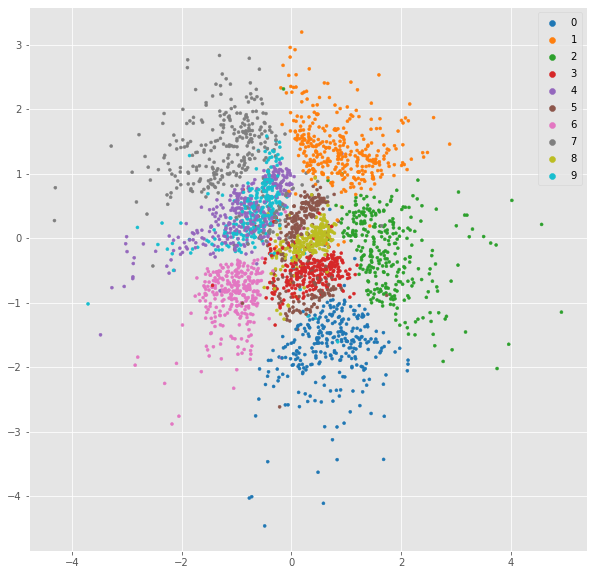

In [18]:
emb = encoder.predict(datax[0:3000,:,:,np.newaxis])
scat = plt.scatter(emb[:,0], emb[:,1], c=y_train[:3000], marker=".", cmap="tab10")
plt.legend(*scat.legend_elements())


Now, the most interesting part. Since our hidden space is approximately normal we can explore it by sampling various points on the grid and decoding them by the decoder. In that way, we can generate new images and get some understanding of hidden space structure. 

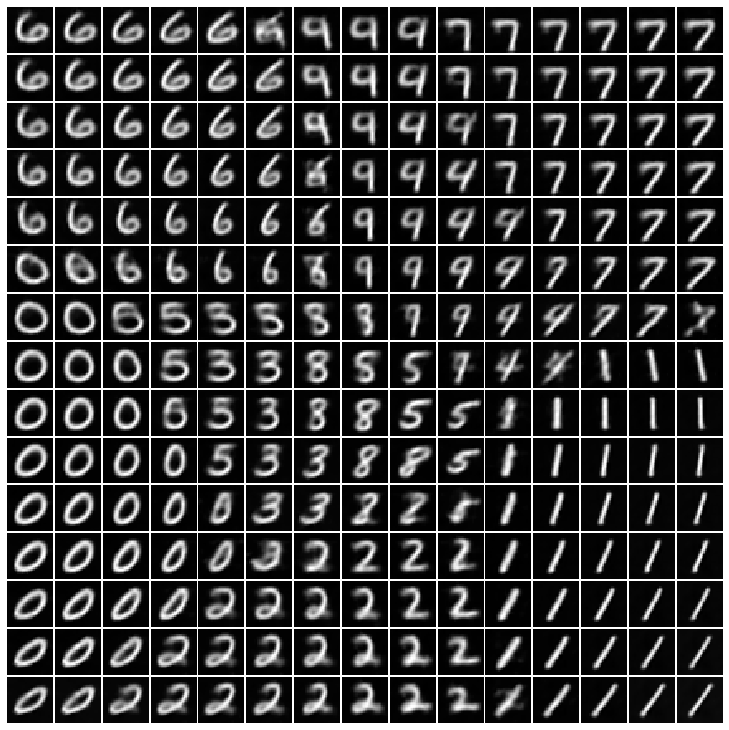

In [26]:
matplotlib.rcParams['figure.figsize'] = (10, 10)

grsize = (15, 15)
c = 0.5

xgrid = np.linspace(-2, 2, grsize[0])
ygrid = np.linspace(-2, 2, grsize[1])

idx = 1
for x in xgrid:
    for y in ygrid:
        decoded = decoder.predict(np.array([[x, y]]))
        plt.subplot(grsize[0], grsize[1], idx)
        plt.imshow(np.squeeze(decoded), cmap="gray")
        plt.axis("off")
        idx += 1
plt.tight_layout(0.2)
